# DBSCAN

In [1]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors, KDTree
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import spatial

from lib.pca import PCAFeatures
import lib.bovw as bovw
from lib.alexnet import AlexNetFeatures
import lib.utils as utils

## 1. PCA Features

In [33]:
train_imgs, train_labels = utils.load_train_images()
print(len(train_imgs))

3500


In [34]:
train_resized_imgs = utils.resize_imgs(train_imgs)
mean_img = utils.get_mean_img(train_resized_imgs)
train_norm_imgs = utils.basic_imgs_normalization(train_resized_imgs)
train_features = utils.image_liniarization(train_norm_imgs)
train_features.shape

(3500, 7500)

In [35]:
pca_300 = PCAFeatures(dim=300)
pca_300.fit(train_features)
train_features_reduced_300 = pca_300.transform(train_features)
print(train_features_reduced_300.shape)

(3500, 300)


In [2]:
def compute_distance_matrix(train_features, metric="euclidean"):
    return metrics.pairwise_distances(train_features, metric=metric, n_jobs=-1)

In order to speed up the fitting process, precompute the distance matrix.

In [36]:
train_distance_matrix = compute_distance_matrix(train_features_reduced_300)
train_distance_matrix.shape

(3500, 3500)

In [3]:
def eps_search(train_distance_matrix, metric="precomputed", k=1):
    """ For each sample point find the k-th closest point and store the distance to it
    Returns the sorted distances
    """
    nn = NearestNeighbors(n_neighbors=k + 1, metric=metric)
    nn.fit(train_distance_matrix)
    dist = nn.kneighbors(train_distance_matrix)[0][:, k]
    dist = np.sort(dist)
    return dist

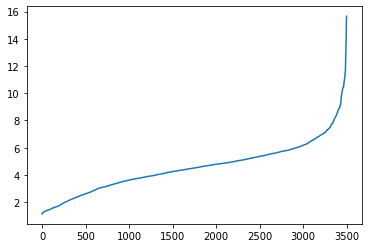

9.16258609917068


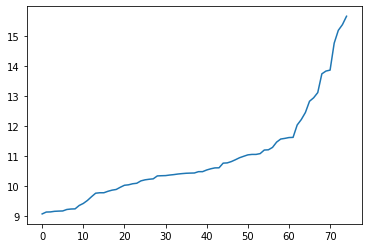

In [37]:
dists = eps_search(train_distance_matrix, k=4)
plt.plot(dists)
plt.show()
plt.plot(dists[3425:3500])
print(dists[3430])

In [20]:
def try_min_samples(eps, min_sample_options):
    """Print number of clusters for different DBSCAN params"""
    for min_samples in min_sample_options:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed", n_jobs=-1)
        dbscan.fit(train_distance_matrix)
        labels_set = set(dbscan.labels_.tolist())
        num_clusters = len(labels_set) - (-1 in labels_set)
        print(f"For min_samples={min_samples}: {num_clusters} clusters")

In [21]:
min_sample_options = list(range(90, 100))
try_min_samples(8.5, min_sample_options)

For min_samples=90: 11 clusters
For min_samples=91: 11 clusters
For min_samples=92: 11 clusters
For min_samples=93: 11 clusters
For min_samples=94: 10 clusters
For min_samples=95: 10 clusters
For min_samples=96: 10 clusters
For min_samples=97: 10 clusters
For min_samples=98: 10 clusters
For min_samples=99: 9 clusters


In [4]:
def print_cluster_sizes(dbscan):
    cnt = Counter(dbscan.labels_.tolist())
    for label in cnt:
        if label == -1:
            continue
        print(f"Cluster {label}: {cnt[label]}")
    print(f"Outliers: {cnt[-1]}")

In [38]:
dbscan = DBSCAN(eps=9, min_samples=4, metric="precomputed", n_jobs=-1)
dbscan.fit(train_distance_matrix)
print_cluster_sizes(dbscan)

Cluster 0: 207
Cluster 1: 20
Cluster 2: 655
Cluster 3: 350
Cluster 4: 241
Cluster 5: 18
Cluster 6: 8
Cluster 7: 114
Cluster 8: 341
Cluster 9: 123
Cluster 10: 109
Cluster 11: 93
Cluster 12: 272
Cluster 13: 274
Cluster 14: 33
Cluster 15: 21
Cluster 16: 104
Cluster 17: 325
Cluster 18: 34
Cluster 19: 16
Cluster 20: 8
Cluster 27: 11
Cluster 21: 21
Cluster 22: 15
Cluster 23: 9
Cluster 28: 5
Cluster 24: 15
Cluster 25: 9
Cluster 26: 7
Cluster 29: 4
Outliers: 38


In [39]:
def dbscan_clustering(eps, min_samples, train_features, train_distance_matrix, train_labels, n_true_clusters):
    """DBSCAN clustering using given features, returns a fitted estimator and a many-to-one
    mapping from the clusters to the training labels based on the most frequent label
    in a cluster.
    """
    # Fit the estimator and predict the labels
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed", n_jobs=-1)
    dbscan.fit(train_distance_matrix)
    predicted_labels = dbscan.labels_

    # compute silhouette scores for every sample
    sil_avg = metrics.silhouette_score(train_features, predicted_labels)
    sample_sil_values = metrics.silhouette_samples(train_features, predicted_labels)

    labels_set = set(dbscan.labels_.tolist())
    n_clusters = len(labels_set) - (-1 in labels_set)
    
    # the silhouette plot for each cluster
    fig, ax = plt.subplots()
    ax.set_xlim([-0.1, 1])
    skip_between = 10
    ax.set_ylim([0, np.count_nonzero(predicted_labels != -1) + (n_clusters + 1) * skip_between])

    y_min = 10
    for i in range(n_clusters):
        sil_values = sample_sil_values[predicted_labels == i]
        sil_values.sort()

        size = sil_values.shape[0]
        y_max = y_min + size

        color = cm.nipy_spectral((i + 1) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_min, y_max),
            0,
            sil_values,
            facecolor=color,
            edgecolor=color,
        )

        ax.text(-0.1, y_min + 0.5 * size, str(i))
        y_min = y_max + skip_between

    ax.set_title(f"Silhouette plot for {n_clusters} clusters")
    ax.set_xlabel("Silhouette scores")
    ax.set_ylabel("Cluster")

    # plot the silhouette mean score
    ax.axvline(x=sil_avg, color="red")

    ax.set_yticks([])
    ax.set_xticks(np.arange(6) / 5)

    plt.show()

    # plot for DBSCAN clustering vs. actual distribution
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(15, 5)

    # use PCA for 2D plot
    pca_2 = PCAFeatures(2)
    pca_2.fit(train_features)
    train_features_2 = pca_2.transform(train_features)

    colors = cm.nipy_spectral((predicted_labels.astype(float) + 1) / n_clusters)
    ax1.scatter(
        train_features_2[:, 0], train_features_2[:, 1],
        marker='.', s=20, c=colors
    )
    ax1.set_title("Clustered data")
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    colors = cm.nipy_spectral(
        (np.array(train_labels).astype(float) + 1) / n_true_clusters
    )
    ax2.scatter(
        train_features_2[:, 0], train_features_2[:, 1],
        marker='.', s=20, c=colors
    )
    ax2.set_title("Actual distribution of the data")
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)

    # compute for each cluster the most frequent training label in that cluster
    cnt_clusters = defaultdict(Counter)
    for true_label, cluster_label in zip(train_labels, predicted_labels):
        cnt_clusters[cluster_label][true_label] += 1
    cluster_to_label = {}
    for cluster in cnt_clusters:
        cluster_to_label[cluster] = cnt_clusters[cluster].most_common(1)[0][0]
    cluster_to_label[-1] = -1

    # remap cluster labels based on the many-to-one relation and plot the generated classes
    remapped_labels = np.array([cluster_to_label[cluster] for cluster in predicted_labels])
    colors = cm.nipy_spectral((remapped_labels.astype(float) + 1) / n_true_clusters)
    ax3.scatter(
        train_features_2[:, 0], train_features_2[:, 1],
        marker='.', s=20, c=colors
    )
    ax3.set_title("Merged clusters using training labels")
    ax3.axes.xaxis.set_visible(False)
    ax3.axes.yaxis.set_visible(False)


    plt.show()

    return dbscan, cluster_to_label

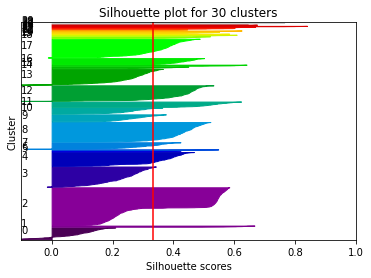

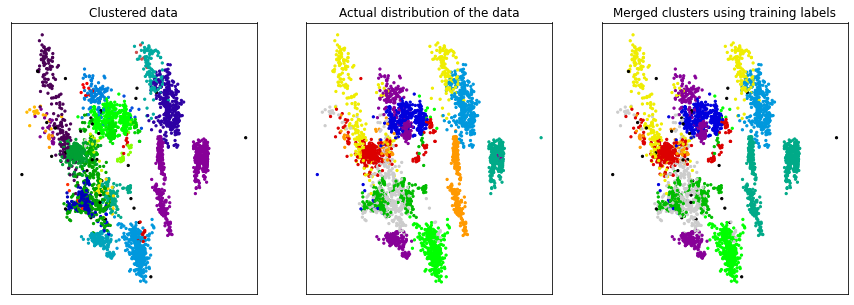

In [40]:
dbscan, cluster_to_label = dbscan_clustering(
    eps=9,
    min_samples=4,
    train_features=train_features_reduced_300,
    train_distance_matrix=train_distance_matrix,
    train_labels=train_labels,
    n_true_clusters=10,
)

In [41]:
predicted_labels = dbscan.labels_
predicted_labels_for_acc = np.array(
    [cluster_to_label[cluster] for cluster in predicted_labels]
)
print(predicted_labels.shape)
predicted_labels_for_nmi = predicted_labels.copy()
cnt = 100
for i in range(len(predicted_labels_for_nmi)):
    if predicted_labels_for_nmi[i] == -1:
        predicted_labels_for_nmi[i] = cnt
        cnt += 1
print(f"Train ACC: {metrics.accuracy_score(train_labels, predicted_labels_for_acc)}")
print(f"Train NMI: {metrics.normalized_mutual_info_score(train_labels, predicted_labels_for_nmi)}")

(3500,)
Train ACC: 0.9017142857142857
Train NMI: 0.8561312954942878


In [15]:
def predict_label_for_test(test_features, train_features, dbscan, cluster_to_label, use_cosine=False):
    """In order to predict the label for a test sample, we use a KD Tree in order to
    find the closest core point for that test point. If the distance to that core
    point is less than EPS, assign the test point to that cluster, otherwise consider
    it an outlier
    """
    if use_cosine:
        # normalize features
        train_features = train_features / np.linalg.norm(
            train_features, axis=1
        ).reshape((len(train_features), 1))
        test_features = test_features / np.linalg.norm(
            test_features, axis=1
        ).reshape((len(test_features), 1))
    kd_tree = KDTree(train_features[dbscan.core_sample_indices_])
    predicted_test_labels_acc = []
    predicted_test_labels_nmi = []
    cnt = 100
    for i in tqdm(range(len(test_features))):
        d, idx = kd_tree.query([test_features[i, :]], k=2)
        closest_core = dbscan.core_sample_indices_[idx[0][1]]
        if use_cosine:
            dist_to_core = spatial.distance.cosine(train_features[closest_core], test_features[i])
        else:
            dist_to_core = d[0][1]
        if dist_to_core <= dbscan.get_params()["eps"]:
            cluster = dbscan.labels_[closest_core]
            assert cluster != -1
            predicted_test_labels_acc.append(
                cluster_to_label[cluster]
            )
            predicted_test_labels_nmi.append(cluster)
        else:
            predicted_test_labels_acc.append(-1)
            predicted_test_labels_nmi.append(cnt)
            cnt += 1
    return (
        np.array(predicted_test_labels_acc),
        np.array(predicted_test_labels_nmi),
    )

In [42]:
test_imgs, test_labels = utils.load_test_images()
print(len(test_imgs))
test_resized_imgs = utils.resize_imgs(test_imgs)
test_norm_imgs = utils.basic_imgs_normalization(test_resized_imgs, mean_img=mean_img)
test_features = utils.image_liniarization(test_norm_imgs)
print(test_features.shape)
test_features_reduced_300 = pca_300.transform(test_features)
print(test_features_reduced_300.shape)

1500
(1500, 7500)
(1500, 300)


In [43]:
test_predicted_labels_acc,  test_predicted_labels_nmi = predict_label_for_test(
    test_features_reduced_300,
    train_features_reduced_300,
    dbscan,
    cluster_to_label
)
print("\n", test_predicted_labels_acc.shape)
print(test_predicted_labels_nmi.shape)
print(f"Train ACC: {metrics.accuracy_score(test_labels, test_predicted_labels_acc)}")
print(f"Train NMI: {metrics.normalized_mutual_info_score(test_labels, test_predicted_labels_nmi)}")

100%|██████████| 1500/1500 [00:00<00:00, 4912.21it/s]
 (1500,)
(1500,)
Train ACC: 0.8986666666666666
Train NMI: 0.8546542264090244



## 2. BOVW

In [41]:
train_imgs, train_labels = utils.load_train_images_cv_grayscale()
print(len(train_imgs))
bag_of_visual_words = bovw.BOVWFeatures(dim=4000)
train_features = bag_of_visual_words.fit_and_get_histograms(train_imgs)
print(train_features.shape)

3500
Performing K-Means
Computing histograms
(3500, 4000)


In [73]:
train_distance_matrix = compute_distance_matrix(train_features, metric="cosine")
train_distance_matrix.shape

(3500, 3500)

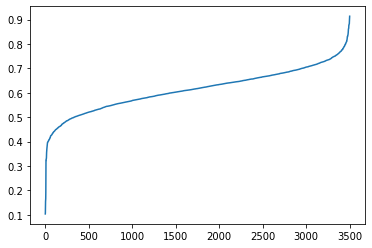

0.807192899042771


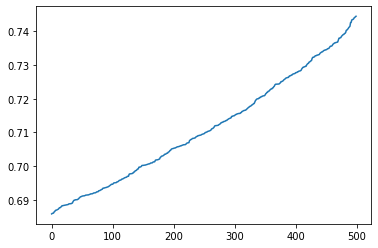

In [101]:
dists = eps_search(train_distance_matrix, k=4)
plt.plot(dists)
plt.show()
plt.plot(dists[2800:3300])
print(dists[3460])

In [97]:
dbscan = DBSCAN(eps=0.7, min_samples=4, metric="precomputed", n_jobs=-1)
dbscan.fit(train_distance_matrix)
print_cluster_sizes(dbscan)

Cluster 0: 207
Cluster 1: 19
Cluster 2: 153
Cluster 7: 324
Cluster 3: 348
Cluster 4: 206
Cluster 5: 22
Cluster 6: 141
Cluster 29: 5
Cluster 8: 316
Cluster 9: 123
Cluster 10: 109
Cluster 11: 93
Cluster 12: 258
Cluster 13: 268
Cluster 21: 32
Cluster 14: 21
Cluster 15: 98
Cluster 16: 96
Cluster 17: 84
Cluster 18: 90
Cluster 35: 4
Cluster 19: 34
Cluster 20: 107
Cluster 22: 24
Cluster 23: 8
Cluster 24: 11
Cluster 25: 23
Cluster 28: 4
Cluster 26: 16
Cluster 27: 34
Cluster 34: 7
Cluster 30: 15
Cluster 31: 5
Cluster 32: 3
Cluster 33: 7
Cluster 36: 4
Outliers: 181


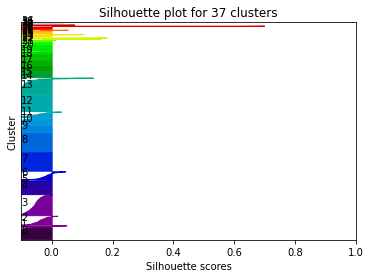

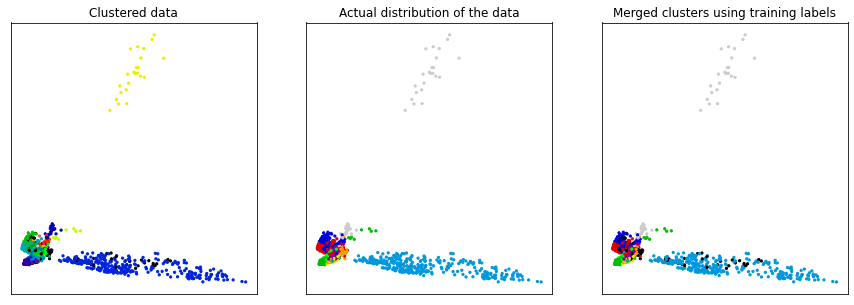

In [102]:
dbscan, cluster_to_label = dbscan_clustering(
    eps=0.7,
    min_samples=4,
    train_features=train_features,
    train_distance_matrix=train_distance_matrix,
    train_labels=train_labels,
    n_true_clusters=10,
)

In [103]:
predicted_labels = dbscan.labels_
predicted_labels_for_acc = np.array(
    [cluster_to_label[cluster] for cluster in predicted_labels]
)
print(predicted_labels.shape)
predicted_labels_for_nmi = predicted_labels.copy()
cnt = 100
for i in range(len(predicted_labels_for_nmi)):
    if predicted_labels_for_nmi[i] == -1:
        predicted_labels_for_nmi[i] = cnt
        cnt += 1
print(f"Train ACC: {metrics.accuracy_score(train_labels, predicted_labels_for_acc)}")
print(f"Train NMI: {metrics.normalized_mutual_info_score(train_labels, predicted_labels_for_nmi)}")

(3500,)
Train ACC: 0.9482857142857143
Train NMI: 0.8171430525778617


In [105]:
test_imgs, test_labels = utils.load_test_images_cv_grayscale()
print(len(test_imgs))
test_features = bag_of_visual_words.get_histograms(test_imgs)
print(test_features.shape)


1500
(1500, 4000)


In [115]:
test_predicted_labels_acc,  test_predicted_labels_nmi = predict_label_for_test(
    test_features,
    train_features,
    dbscan,
    cluster_to_label,
    use_cosine=True,
)
print("\n", test_predicted_labels_acc.shape)
print(test_predicted_labels_nmi.shape)
print(f"Test ACC: {metrics.accuracy_score(test_labels, test_predicted_labels_acc)}")
print(f"Test NMI: {metrics.normalized_mutual_info_score(test_labels, test_predicted_labels_nmi)}")

100%|██████████| 1500/1500 [00:23<00:00, 63.58it/s]
 (1500,)
(1500,)
Test ACC: 0.9
Test NMI: 0.7908828826386672



## 3. AlexNet Features

In [7]:
train_imgs, train_labels = utils.load_train_images(as_pil=True)
print(len(train_imgs))
alexnet_features = AlexNetFeatures()
train_features = alexnet_features.get_embeddings(train_imgs)
print(train_features.shape)

3500
(3500, 64896)


In [8]:
train_distance_matrix = compute_distance_matrix(train_features, metric="cosine")
train_distance_matrix.shape

(3500, 3500)

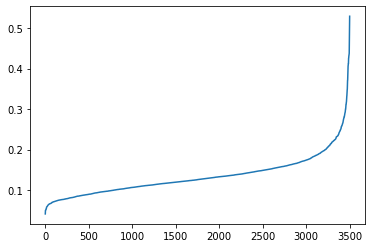

0.21876901


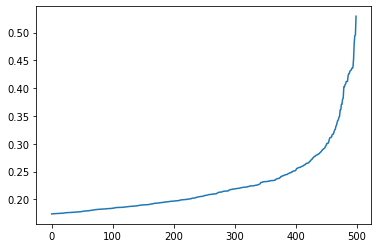

In [9]:
dists = eps_search(train_distance_matrix, k=4)
plt.plot(dists)
plt.show()
plt.plot(dists[3000:3500])
print(dists[3300])

In [10]:
dbscan = DBSCAN(eps=0.3, min_samples=4, metric="precomputed", n_jobs=-1)
dbscan.fit(train_distance_matrix)
print_cluster_sizes(dbscan)

Cluster 0: 208
Cluster 1: 20
Cluster 2: 649
Cluster 3: 350
Cluster 4: 208
Cluster 5: 21
Cluster 6: 8
Cluster 7: 113
Cluster 8: 341
Cluster 9: 123
Cluster 10: 110
Cluster 11: 93
Cluster 12: 273
Cluster 13: 274
Cluster 14: 35
Cluster 15: 21
Cluster 16: 105
Cluster 17: 333
Cluster 28: 16
Cluster 18: 34
Cluster 19: 16
Cluster 20: 8
Cluster 21: 11
Cluster 22: 23
Cluster 23: 16
Cluster 24: 9
Cluster 25: 34
Cluster 26: 4
Cluster 27: 6
Cluster 29: 9
Cluster 30: 7
Outliers: 22


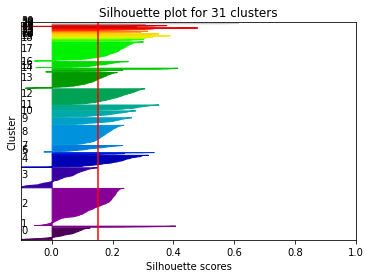

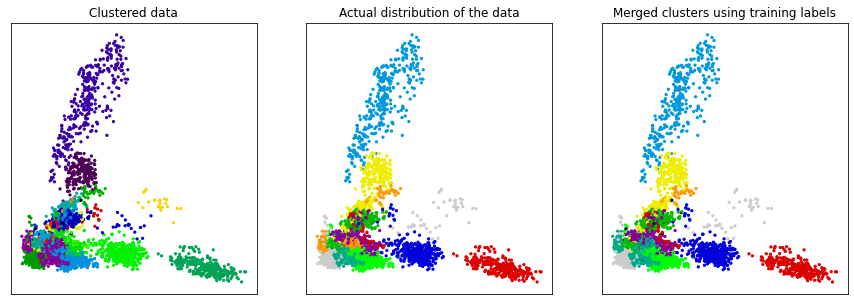

In [11]:
dbscan, cluster_to_label = dbscan_clustering(
    eps=0.3,
    min_samples=4,
    train_features=train_features,
    train_distance_matrix=train_distance_matrix,
    train_labels=train_labels,
    n_true_clusters=10,
)

In [12]:
predicted_labels = dbscan.labels_
predicted_labels_for_acc = np.array(
    [cluster_to_label[cluster] for cluster in predicted_labels]
)
print(predicted_labels.shape)
predicted_labels_for_nmi = predicted_labels.copy()
cnt = 100
for i in range(len(predicted_labels_for_nmi)):
    if predicted_labels_for_nmi[i] == -1:
        predicted_labels_for_nmi[i] = cnt
        cnt += 1
print(f"Train ACC: {metrics.accuracy_score(train_labels, predicted_labels_for_acc)}")
print(f"Train NMI: {metrics.normalized_mutual_info_score(train_labels, predicted_labels_for_nmi)}")

(3500,)
Train ACC: 0.9082857142857143
Train NMI: 0.8592570160922928


In [13]:
test_imgs, test_labels = utils.load_test_images(as_pil=True)
print(len(test_imgs))
test_features = alexnet_features.get_embeddings(test_imgs)
print(test_features.shape)

1500
(1500, 64896)


In [14]:
test_predicted_labels_acc,  test_predicted_labels_nmi = predict_label_for_test(
    test_features,
    train_features,
    dbscan,
    cluster_to_label,
    use_cosine=True,
)
print("\n", test_predicted_labels_acc.shape)
print(test_predicted_labels_nmi.shape)
print(f"Test ACC: {metrics.accuracy_score(test_labels, test_predicted_labels_acc)}")
print(f"Test NMI: {metrics.normalized_mutual_info_score(test_labels, test_predicted_labels_nmi)}")

100%|██████████| 1500/1500 [05:10<00:00,  4.83it/s]
 (1500,)
(1500,)
Test ACC: 0.9013333333333333
Test NMI: 0.856017243709211



## 4. Dlib Facenet Features

In [16]:
train_features = None
with open("./.emb_cache/dlib/train_embs.bin", "rb") as f:
    train_features = pickle.load(f)
train_features.shape

(3500, 128)

In [18]:
train_distance_matrix = compute_distance_matrix(train_features)
train_distance_matrix.shape

(3500, 3500)

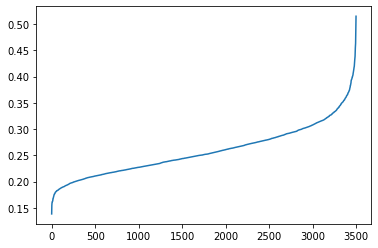

0.3410159067248132


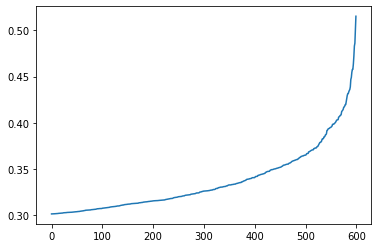

In [27]:
dists = eps_search(train_distance_matrix, k=4)
plt.plot(dists)
plt.show()
plt.plot(dists[2900:3500])
print(dists[3300])

In [28]:
dbscan = DBSCAN(eps=0.4, min_samples=4, metric="precomputed", n_jobs=-1)
dbscan.fit(train_distance_matrix)
print_cluster_sizes(dbscan)

Cluster 0: 343
Cluster 1: 316
Cluster 2: 340
Cluster 3: 350
Cluster 4: 349
Cluster 5: 242
Cluster 6: 347
Cluster 8: 350
Cluster 7: 350
Cluster 9: 91
Cluster 10: 350
Cluster 11: 34
Cluster 12: 5
Cluster 13: 9
Cluster 14: 6
Cluster 15: 7
Outliers: 11


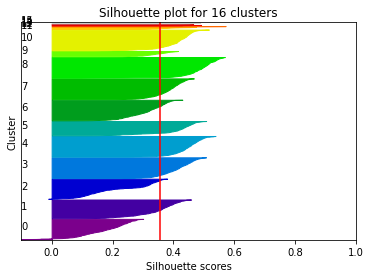

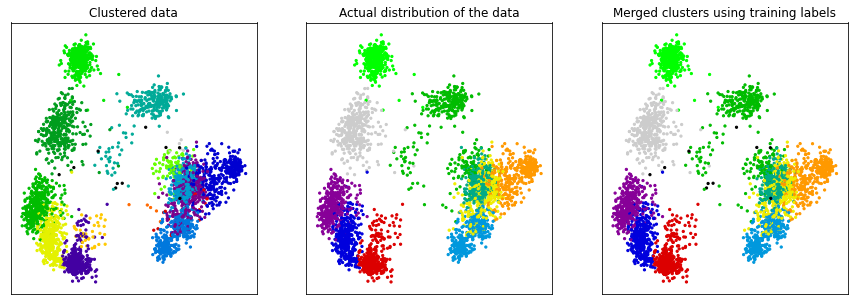

In [29]:
dbscan, cluster_to_label = dbscan_clustering(
    eps=0.4,
    min_samples=4,
    train_features=train_features,
    train_distance_matrix=train_distance_matrix,
    train_labels=train_labels,
    n_true_clusters=10,
)

In [30]:
predicted_labels = dbscan.labels_
predicted_labels_for_acc = np.array(
    [cluster_to_label[cluster] for cluster in predicted_labels]
)
print(predicted_labels.shape)
predicted_labels_for_nmi = predicted_labels.copy()
cnt = 100
for i in range(len(predicted_labels_for_nmi)):
    if predicted_labels_for_nmi[i] == -1:
        predicted_labels_for_nmi[i] = cnt
        cnt += 1
print(f"Train ACC: {metrics.accuracy_score(train_labels, predicted_labels_for_acc)}")
print(f"Train NMI: {metrics.normalized_mutual_info_score(train_labels, predicted_labels_for_nmi)}")

(3500,)
Train ACC: 0.9968571428571429
Train NMI: 0.9690594995758054


In [31]:
test_features = None
with open("./.emb_cache/dlib/test_embs.bin", "rb") as f:
    test_features = pickle.load(f)
test_features.shape

(1500, 128)

In [32]:
test_predicted_labels_acc,  test_predicted_labels_nmi = predict_label_for_test(
    test_features,
    train_features,
    dbscan,
    cluster_to_label,
)
print("\n", test_predicted_labels_acc.shape)
print(test_predicted_labels_nmi.shape)
print(f"Test ACC: {metrics.accuracy_score(test_labels, test_predicted_labels_acc)}")
print(f"Test NMI: {metrics.normalized_mutual_info_score(test_labels, test_predicted_labels_nmi)}")

100%|██████████| 1500/1500 [00:00<00:00, 3285.20it/s]
 (1500,)
(1500,)
Test ACC: 0.9893333333333333
Test NMI: 0.9617344696439029

